## Use ranking loss (spearman and weighted spearman loss) for CT image age prediction
start at 10/23/2023 by Hao Lu for the first version

by Hao:
    I don't know it will work or not. Let's just try. I'm a little nervous.

## Import models

In [1]:
import os
import glob
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    Flipd,
    RandAffined,
    ToTensord,
    RepeatChanneld,
)
from monai.data import CacheDataset, DataLoader, Dataset, DistributedSampler, SmartCacheDataset, load_decathlon_datalist
# import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import json
import torch
import torch.nn as nn
from monai.networks.nets import UNet,SEResNet50
import torchsort
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR

## Load data
data director: /isilon/datalake/cialab/original/cialab/image_database/d00143/2022_dataset/original/
label director: /isilon/datalake/cialab/original/cialab/image_database/d00143/2022_dataset/labels.json

In [2]:
# set data directory


data_dir = "/isilon/datalake/cialab/original/cialab/image_database/d00143/2022_dataset/original/"
label_dir = "/isilon/datalake/cialab/original/cialab/image_database/d00143/2022_dataset/"
label_file = "labels.json"
with open(os.path.join(label_dir, label_file), 'r') as f:
    labels = json.load(f)

# get the image file names and labels
image_name_list = [os.path.join(data_dir, str(image_name['id'])+'.nii') for image_name in labels]


label_list = [label['age'] for label in labels]
max_age = max(label_list)
min_age = min(label_list)
label_list = [[(label-min_age)/(max_age-min_age)] for label in label_list] # Not sure it is still a good idea to normalize the label for spearman loss

data_dicts = []
for image_name, label in zip(image_name_list, label_list):
    if os.path.exists(image_name):
        data_dicts.append({"image": image_name, "label": label})
train_files, val_files = data_dicts[:-200], data_dicts[-200:]

In [3]:
# define hyperparameters
batch_size = 20
num_workers = 10
train_sampler = None
lr = 1


In [4]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-500,
            a_max=1500, 
            b_min=0.0, 
            b_max=1.0, 
            clip=True,
        ),
        # RepeatChanneld(keys=["image"],repeats=3),
        ToTensord(keys=["image", "label"]),
        # RandCropByPosNegLabeld(
        #     keys=["image", "label"],
        #     label_key="label",
        #     spatial_size=(96, 96),
        #     pos=1,
        #     neg=1,
        #     num_samples=4,
        #     image_key="image",
        #     image_threshold=0,
        # ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-500,
            a_max=1500,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        # # RepeatChanneld(keys=["image"],repeats=3),
        ToTensord(keys=["image", "label"]),
    ]
)

train_ds = Dataset(data=train_files, transform=train_transforms)
val_ds = Dataset(data=val_files, transform=val_transforms)

train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers, sampler=train_sampler,shuffle=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=True)

## check the dataloader 

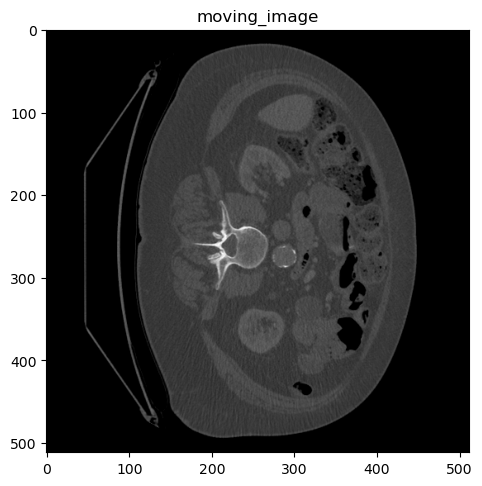

In [5]:
from monai.utils import set_determinism, first
import matplotlib.pyplot as plt

check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
iamge = check_data["image"][0][0]
label = check_data["label"][0]


# plot the slice [:, :, 50]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("moving_image")
plt.imshow(iamge[:, :], cmap="gray")



plt.show()
plt.show()

In [6]:
check_data["label"].shape

torch.Size([1, 1])

## Spearman loss

In [5]:
class WeightedSpearmanLoss(nn.Module):
    """
        Spearman Loss
    """

    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
    
    def forward(self, pred: torch.tensor, target: torch.tensor, target_sort: torch.tensor, k=2, s=5, **kw) -> torch.tensor:
        
        pred_rank = torchsort.soft_rank(pred, **kw)
        target_rank = torchsort.soft_rank(target, **kw)
        
        target_sort = target_sort.flatten()
        W = torch.sqrt( (target_sort[pred_rank.flatten().long()-1] - target_sort[target_rank.flatten().long()-1]) ** 2 ).requires_grad_(False)
        # w = torch.tensor([0,0,0,0,19])
        pred_rank = pred_rank - pred_rank.mean()
        pred_rank = pred_rank / pred_rank.norm()
        target_rank = target_rank - target_rank.mean()
        target_rank = target_rank / target_rank.norm()
        
        W = 1/(1 + torch.exp(-k*(W-s)))
        W = W / W.sum()*len(W)
        return -(pred_rank * target_rank * W).sum()
    
class SpearmanLoss(nn.Module):
    """
        Spearman Loss
    """

    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
    
    def forward(self, pred: torch.tensor, target: torch.tensor, **kw) -> torch.tensor:
        """
            pred: (B, 1)
            target: (B, 1)
        """
        pred = torchsort.soft_rank(pred, **kw)
        target = torchsort.soft_rank(target, **kw)
        pred = pred - pred.mean()
        pred = pred / pred.norm()
        target = target - target.mean()
        target = target / target.norm()
        return -(pred * target).sum()
    
class SigmoidWrapper(nn.Module):
    def __init__(self, base_model):
        super(SigmoidWrapper, self).__init__()
        self.base_model = base_model
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.base_model(x)
        x = self.sigmoid(x)
        return x

In [6]:
device = torch.device("cuda:0")
model = SEResNet50(spatial_dims=2, in_channels=1, pretrained=False, num_classes=1)
# model.load_state_dict(torch.load("./ranking/weighted_best_metric_model_lr_0.1_batchsize_20.pth"))
# model = SigmoidWrapper(model)
model.to(device)
huber_loss = nn.SmoothL1Loss()
spearman_loss = SpearmanLoss()
weighted_spearman_loss = WeightedSpearmanLoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

# Number of epochs
loop_epochs = 100
num_loop = 2

# Cosine learning rate scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=loop_epochs, eta_min=0.001)



In [7]:
def spearman_hard(traget1, pred):
    pred = get_rank(pred, [i for i in range(pred.shape[1])]).float()
    traget1 = get_rank(traget1, [i for i in range(traget1.shape[1])]).float()
    pred = pred - pred.mean()
    pred = pred / pred.norm()
    traget1 = traget1 - traget1.mean()
    traget1 = traget1 / traget1.norm()
    return (pred * traget1).sum()

def weighted_spearmanr(pred, target, target_sort, k=2, s=5, **kw):
    pred_rank = torchsort.soft_rank(pred, **kw)
    target_rank = torchsort.soft_rank(target, **kw)
    
    target_sort = target_sort.flatten()
    W = torch.sqrt( (target_sort[pred_rank.flatten().long()-1] - target_sort[target_rank.flatten().long()-1]) ** 2 ).requires_grad_(False)
    # w = torch.tensor([0,0,0,0,19])
    pred_rank = pred_rank - pred_rank.mean()
    pred_rank = pred_rank / pred_rank.norm()
    target_rank = target_rank - target_rank.mean()
    target_rank = target_rank / target_rank.norm()
    
    W = 1/(1 + torch.exp(-k*(W-s)))

    return (pred_rank * target_rank * W).sum(), W

def spearmanr(pred, target, **kw):
    pred = torchsort.soft_rank(pred, **kw)
    target = torchsort.soft_rank(target, **kw)
    pred = pred - pred.mean()
    pred = pred / pred.norm()
    target = target - target.mean()
    target = target / target.norm()
    return (pred * target).sum()

def get_rank(x, indices):
   vals = x[list(range(len(x))), indices]
   return (x < vals[:, None]).long().sum(1)

def spearman_hard_eval(traget1, pred):
    pred = get_rank_eval(pred).float()
    traget1 = get_rank_eval(traget1).float()
    pred = pred - pred.mean()
    pred = pred / pred.norm()
    traget1 = traget1 - traget1.mean()
    traget1 = traget1 / traget1.norm()
    return (pred * traget1).sum()

def get_rank_eval(x):
   vals = x[0, :]
   return (x < vals[:, None]).long().sum(1)

In [8]:
x = torch.tensor([[1,2,3,4,5,5,4,3,2,1]])
get_rank_eval(x)

tensor([0, 2, 4, 6, 8, 8, 6, 4, 2, 0])

----------
epoch 1/200
----------
epoch 2/200
----------
epoch 3/200
----------
epoch 4/200
----------
epoch 5/200
current epoch: 5 current spearman: -0.0738 best spearman: -0.0738
----------
epoch 6/200
----------
epoch 7/200
----------
epoch 8/200
----------
epoch 9/200
----------
epoch 10/200
current epoch: 10 current spearman: -0.0798 best spearman: -0.0738
----------
epoch 11/200
----------
epoch 12/200
----------
epoch 13/200
----------
epoch 14/200
----------
epoch 15/200
current epoch: 15 current spearman: -0.0472 best spearman: -0.0472
----------
epoch 16/200
----------
epoch 17/200
----------
epoch 18/200
----------
epoch 19/200
----------
epoch 20/200
current epoch: 20 current spearman: -0.0133 best spearman: -0.0133
----------
epoch 21/200
----------
epoch 22/200
----------
epoch 23/200
----------
epoch 24/200
----------
epoch 25/200
current epoch: 25 current spearman: -0.1714 best spearman: -0.0133
----------
epoch 26/200
----------
epoch 27/200
----------
epoch 28/200
---

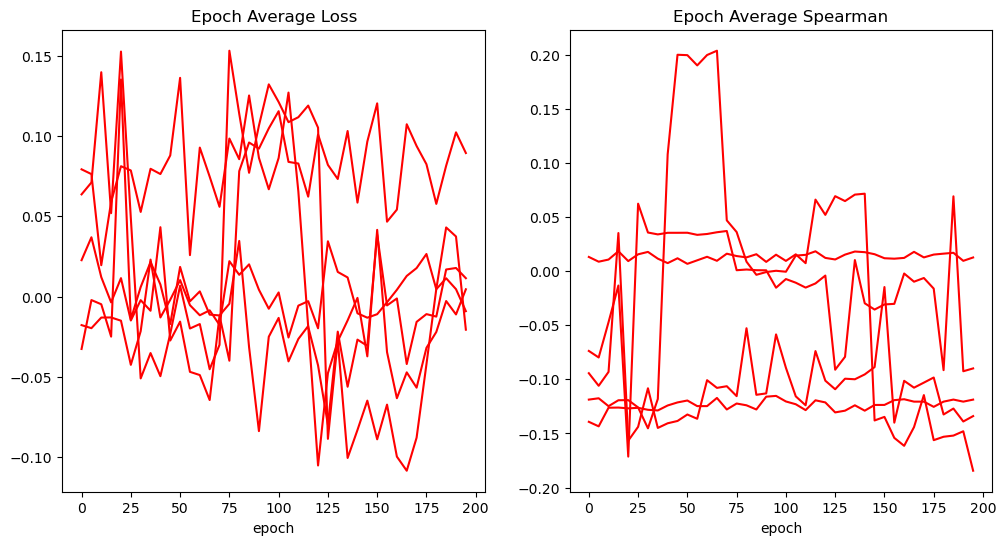

In [11]:
val_interval = 5

for lr in [0.0001, 0.001, 0.01, 0.1, 1]:

    metric_val = []
    loss_val = []
    best_metric = -1
    for epoch in range(loop_epochs * num_loop):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{loop_epochs * num_loop}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            label_sort = torch.sort(labels.t(), dim=1, descending=False)[0]
            loss = weighted_spearman_loss(outputs.t(), labels.t(), label_sort)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            # print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        epoch_loss /= step
        # Step the scheduler
        scheduler.step()
        # print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch+1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                val_spearman_metric = 0
                val_step = 0
                for val_data in val_loader:
                    val_images, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    val_outputs = model(val_images)
                    val_loss = spearman_hard_eval(val_outputs.t(), val_labels.t())
                    val_spearman_metric += val_loss
                    val_step += 1
                val_spearman_metric /= val_step
                if val_spearman_metric > best_metric:
                    best_metric = val_spearman_metric
                    torch.save(model.state_dict(), "weighted_best_metric_model_lr_{}_batchsize_{}.pth".format(lr, batch_size))
                print(f"current epoch: {epoch + 1} current spearman: {val_spearman_metric:.4f} best spearman: {best_metric:.4f}")
                metric_val.append(val_spearman_metric.cpu())
                loss_val.append(epoch_loss)

    # Plot the loss curve
    plt.figure("train", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Epoch Average Loss")
    x = [i*val_interval for i in range(len(loss_val))]
    plt.xlabel("epoch")
    plt.plot(x, loss_val, color="red")
    plt.subplot(1, 2, 2)
    plt.title("Epoch Average Spearman")
    x = [i*val_interval for i in range(len(metric_val))]
    plt.xlabel("epoch")
    plt.plot(x, metric_val, color="red")
    plt.savefig("weighted_loss_lr_{}_batchsize_{}.png".format(lr, batch_size))
    plt.close("train")
    # save the loss and metric
    with open("weighted_loss_lr_{}_batchsize_{}.txt".format(lr, batch_size), "w") as f:
        for i in loss_val:
            f.write(str(i))
            f.write("\n")
    with open("weighted_metric_lr_{}_batchsize_{}.txt".format(lr, batch_size), "w") as f:
        for i in metric_val:
            f.write(str(i))
            f.write("\n")

## Check the best model saved and see the output of them

In [10]:
os.getcwd()

'/isilon/datalake/cialab/scratch/cialab/Hao/work_record/Project2_CT_image/codes/CT_age'

In [12]:
dst = torch.load("./ranking/weighted_best_metric_model_lr_0.1_batchsize_20.pth")
model.load_state_dict(dst)
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        if i > 2:
            break
        val_images, val_labels = (val_data["image"].to(device),val_data["label"].to(device),)
        val_outputs = model(val_images)
        print("predict: ",val_outputs)
        print("labels: ",val_labels)
        print("predict rank: ",get_rank_eval(val_outputs.t()))
        print("label rank: ",get_rank_eval(val_labels.t()))

predict:  metatensor([[ -791395.0625],
        [-2115528.5000],
        [-1028480.0625],
        [ -957967.0000],
        [-1112121.0000],
        [-1112121.0000],
        [ -876193.9375],
        [-1093528.1250],
        [ -882849.3750],
        [-1184442.7500],
        [-1190512.2500],
        [ -964964.0625],
        [-2237453.7500],
        [ -979445.4375],
        [-3271597.5000],
        [-1210631.7500],
        [-1106265.2500],
        [ -992372.9375],
        [-3544630.2500],
        [-1039359.8125]], device='cuda:0')
labels:  metatensor([[0.2051],
        [0.4103],
        [0.1795],
        [0.5897],
        [0.2564],
        [0.2564],
        [0.2308],
        [0.5641],
        [0.3077],
        [0.2821],
        [0.0256],
        [0.2821],
        [0.0256],
        [0.3333],
        [0.4615],
        [0.0256],
        [0.2051],
        [0.5897],
        [0.1538],
        [0.4872]], device='cuda:0')
predict rank:  metatensor([19,  3, 12, 16,  7,  7, 18, 10, 17,  6,  5, 15,  2

In [ ]:
# exit()

: 